In [1]:
import os
import pathlib
import json
import random
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score)
from sklearn.manifold import TSNE

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")


In [2]:
# ------------------------------
# 0. Environment / reproducibility
# ------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

TensorFlow: 2.20.0
GPUs: []


In [3]:
# ------------------------------
# 1. Config / Hyperparameters
# ------------------------------
EXTRACT_DIR = "gtzan" 
GENRE_ROOT = pathlib.Path(EXTRACT_DIR) / "genres_original"

SAMPLE_RATE = 22050
DURATION = 30    
N_MELS = 128
N_FFT = 2048
HOP_LEN = 512
SEG_LEN = 3          
SEG_SAMPLES = SEG_LEN * SAMPLE_RATE

BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-3
REPORT_DIR = "report_artifacts"
MODEL_PATH = pathlib.Path(REPORT_DIR) / "genre_cnn.keras"  
LABEL_ENCODER_JSON = "label_encoder.json"

AUGMENT_TRAIN = True   
AUGMENT_FACTOR = 1      


os.makedirs(REPORT_DIR, exist_ok=True)

In [4]:
# ------------------------------
# 2. Dataset checks & metadata
# ------------------------------
if not GENRE_ROOT.exists():
    raise FileNotFoundError(
        f"GTZAN not found at {GENRE_ROOT.absolute()}.\n"
        "Please download the dataset (e.g. from Kaggle) and unzip it so that\n"
        f"{GENRE_ROOT}/<genre>/xxx.wav files exist."
    )

GENRES = sorted([d.name for d in GENRE_ROOT.iterdir() if d.is_dir()])
if not GENRES:
    raise RuntimeError("No genre subdirectories found in GTZAN folder.")

print("Found genres:", GENRES)
print("Number of genres:", len(GENRES))

DATASET_REFERENCE = (
    "GTZAN Music Genre Dataset (Ref: [12]). Source: commonly available via Kaggle or "
    "the original GTZAN repository. 1000 audio files: 10 genres × 100 tracks, "
    "each 30 seconds long, sample rate 22050 Hz."
)

Found genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Number of genres: 10


In [5]:
# ------------------------------
# 3. Audio utilities & augmentation
# ------------------------------
def load_audio(path, sr=SAMPLE_RATE, duration=DURATION, offset=0.0):
    y, sr = librosa.load(path, sr=sr, offset=offset, duration=duration)
    return y, sr

def audio_to_mel(y, sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LEN):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db  

def augment_audio(y, sr):
    """Apply one random augmentation: small pitch shift, small time stretch, or add noise."""
    choice = random.choice(["pitch", "stretch", "noise", "none"])
    if choice == "pitch":
        n_steps = random.uniform(-2.0, 2.0) 
        try:
            y_aug = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
        except Exception:
            y_aug = y
    elif choice == "stretch":
        rate = random.uniform(0.9, 1.1)
        try:
            y_aug = librosa.effects.time_stretch(y, rate)
            if len(y_aug) < len(y):
                y_aug = np.pad(y_aug, (0, len(y) - len(y_aug)), mode="constant")
            else:
                y_aug = y_aug[:len(y)]
        except Exception:
            y_aug = y
    elif choice == "noise":
        noise = np.random.randn(len(y)) * 0.005 * np.max(np.abs(y))
        y_aug = y + noise
    else:
        y_aug = y
    return y_aug

def slice_into_segments(y, sr, seg_len=SEG_LEN):
    """Return list of raw waveform segments (each seg_len seconds)."""
    seg_samples = int(seg_len * sr)
    segments = []
    for start in range(0, len(y) - seg_samples + 1, seg_samples):
        segments.append(y[start:start + seg_samples])
    return segments

In [6]:
# ------------------------------
# 4. Build dataset (with optional augmentation)
# ------------------------------
def build_dataset(augment=False, augment_factor=0):
    X, y_labels = [], []
    skipped = 0
    for g in GENRES:
        genre_folder = pathlib.Path(EXTRACT_DIR) / "genres_original" / g
        files = list(genre_folder.glob("*.wav"))
        if not files:
            continue
        print(f"Processing genre {g} ({len(files)} files)")
        for fpath in files:
            try:
                y, sr = load_audio(str(fpath), sr=SAMPLE_RATE, duration=DURATION)
                segments = slice_into_segments(y, sr, seg_len=SEG_LEN)
                for seg in segments:
                    mel = audio_to_mel(seg, sr)
                    X.append(mel)
                    y_labels.append(g)
                    if augment and augment_factor > 0:
                        for _ in range(augment_factor):
                            seg_aug = augment_audio(seg, sr)
                            mel_aug = audio_to_mel(seg_aug, sr)
                            X.append(mel_aug)
                            y_labels.append(g)
            except Exception as e:
                skipped += 1
                print("SKIPPED", fpath, "->", e)
                continue
    if not X:
        raise RuntimeError("No data loaded.")
    X_np = np.array(X)[..., np.newaxis]  
    le = LabelEncoder()
    y_np = le.fit_transform(y_labels)
    print(f"Loaded {len(X_np)} segments; skipped {skipped} files.")
    return X_np, y_np, le

X_all, y_all, label_enc = build_dataset(augment=False, augment_factor=0)

meta = {
    "dataset_reference": DATASET_REFERENCE,
    "num_genres": len(GENRES),
    "genres": GENRES,
    "num_segments": int(X_all.shape[0]),
    "segment_duration_seconds": SEG_LEN,
    "mel_shape": X_all.shape[1:],
}
with open(pathlib.Path(REPORT_DIR) / "dataset_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

Processing genre blues (100 files)
Processing genre classical (100 files)
Processing genre country (100 files)
Processing genre disco (100 files)
Processing genre hiphop (100 files)
Processing genre jazz (100 files)
SKIPPED gtzan\genres_original\jazz\jazz.00054.wav -> 
Processing genre metal (100 files)
Processing genre pop (100 files)
Processing genre reggae (100 files)
Processing genre rock (100 files)
Loaded 9981 segments; skipped 1 files.


In [7]:
# ------------------------------
# 5. Data splits (train/val/test) - stratified by label
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.15, random_state=SEED, stratify=y_all)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=SEED, stratify=y_train)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (7210, 128, 130, 1) Val: (1273, 128, 130, 1) Test: (1498, 128, 130, 1)


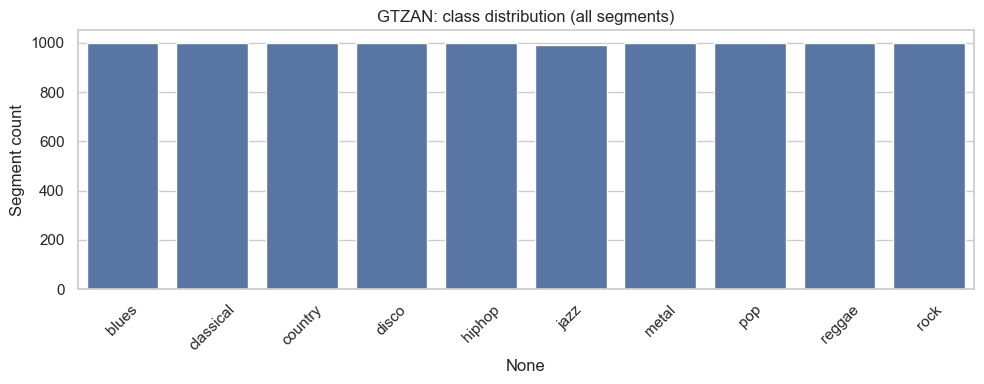

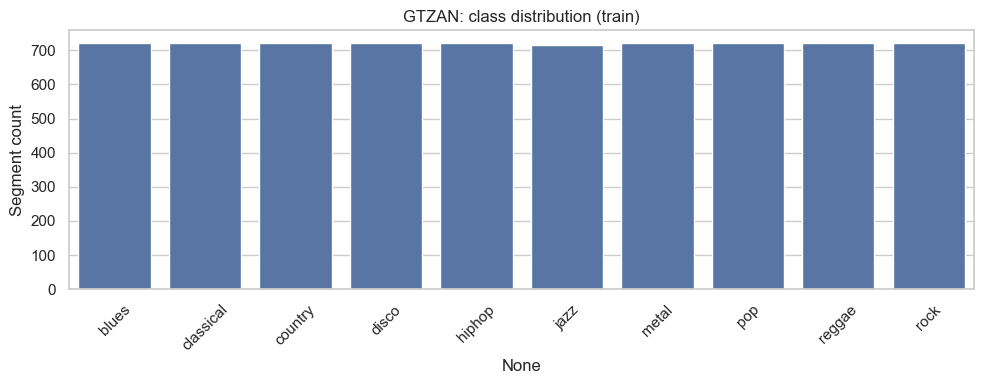

In [8]:
# ------------------------------
# 6. Class distribution visualization
# ------------------------------
def plot_class_distribution(y, label_encoder, title, fname):
    counts = pd.Series(label_encoder.inverse_transform(y)).value_counts().reindex(label_encoder.classes_)
    plt.figure(figsize=(10,4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(title)
    plt.ylabel("Segment count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

plot_class_distribution(y_all, label_enc, "GTZAN: class distribution (all segments)", pathlib.Path(REPORT_DIR) / "class_distribution_all.png")
plot_class_distribution(y_train, label_enc, "GTZAN: class distribution (train)", pathlib.Path(REPORT_DIR) / "class_distribution_train.png")

In [9]:
# ------------------------------
# 7. Model definition (2D CNN on mel spectrogram images)
# ------------------------------
def make_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),            
        layers.Resizing(128, 128),                  
        layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.GlobalMaxPool2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu", name="embedding"),
        layers.Dense(num_classes, activation="softmax", name="output")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = make_model(X_train.shape[1:], len(GENRES))
model.summary()

try:
    tf.keras.utils.plot_model(model, to_file=pathlib.Path(REPORT_DIR) / "model_architecture.png", show_shapes=True)
    print("Model architecture saved to report_artifacts/model_architecture.png")
except Exception as e:
    print("Could not save model architecture diagram (requires pydot/graphviz).", e)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Model architecture saved to report_artifacts/model_architecture.png


Model summary saved to report_artifacts\model_summary.txt


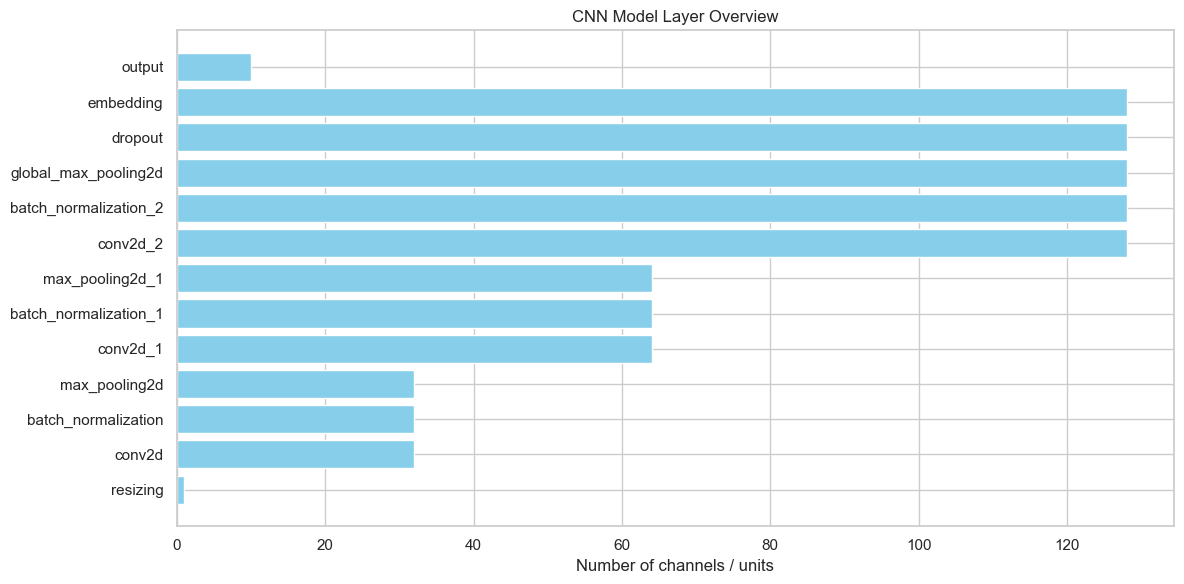

Layer overview plot saved to report_artifacts\model_overview.png

Model Flowchart:
01: resizing             -> (None, 128, 128, 1)
02: conv2d               -> (None, 128, 128, 32)
03: batch_normalization  -> (None, 128, 128, 32)
04: max_pooling2d        -> (None, 64, 64, 32)
05: conv2d_1             -> (None, 64, 64, 64)
06: batch_normalization_1 -> (None, 64, 64, 64)
07: max_pooling2d_1      -> (None, 32, 32, 64)
08: conv2d_2             -> (None, 32, 32, 128)
09: batch_normalization_2 -> (None, 32, 32, 128)
10: global_max_pooling2d -> (None, 128)
11: dropout              -> (None, 128)
12: embedding            -> (None, 128)
13: output               -> (None, 10)


In [10]:
# ------------------------------
# Model summary & visualization without pydot/graphviz
# ------------------------------
import matplotlib.pyplot as plt

summary_file = pathlib.Path(REPORT_DIR) / "model_summary.txt"
with open(summary_file, "w", encoding="utf-8") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))
print("Model summary saved to", summary_file)

layer_names = [layer.name for layer in model.layers]
layer_shapes = []
for layer in model.layers:
    try:
        shape = layer.output.shape
        layer_shapes.append(shape)
    except AttributeError:
        layer_shapes.append(None) 

layer_channels = []
for s in layer_shapes:
    if s is None:
        layer_channels.append(0)
    elif len(s) >= 4:  
        layer_channels.append(int(s[-1]))
    elif len(s) == 2: 
        layer_channels.append(int(s[-1]))
    else:
        layer_channels.append(0)

plt.figure(figsize=(12, 6))
plt.barh(layer_names, layer_channels, color="skyblue")
plt.xlabel("Number of channels / units")
plt.title("CNN Model Layer Overview")
plt.tight_layout()
plt.savefig(pathlib.Path(REPORT_DIR) / "model_overview.png")
plt.show()
print("Layer overview plot saved to", pathlib.Path(REPORT_DIR) / "model_overview.png")

print("\nModel Flowchart:")
for i, (name, shape) in enumerate(zip(layer_names, layer_shapes)):
    print(f"{i+1:02d}: {name:20s} -> {shape}")

In [ ]:
# ------------------------------
# 8. Callbacks & training
# ------------------------------
cb = [
    callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5),
    callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor="val_loss")
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    verbose=2
)

hist_df = pd.DataFrame(history.history)
hist_df.to_csv(pathlib.Path(REPORT_DIR) / "training_history.csv", index=False)

def plot_training_curves(history, fname_acc, fname_loss):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title("Accuracy: train vs val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname_acc)
    plt.close()

    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss: train vs val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname_loss)
    plt.close()

plot_training_curves(
    history,
    pathlib.Path(REPORT_DIR) / "train_val_accuracy.png",
    pathlib.Path(REPORT_DIR) / "train_val_loss.png"
)

Epoch 1/25
226/226 - 125s - 554ms/step - accuracy: 0.2713 - loss: 2.5394 - val_accuracy: 0.4258 - val_loss: 1.5834 - learning_rate: 1.0000e-03
Epoch 2/25


In [ ]:
# ------------------------------
# 9. Evaluate on test set & metrics table
# ------------------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}  Test accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

report_dict = classification_report(y_test, y_pred, target_names=label_enc.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(4)
report_df.to_csv(pathlib.Path(REPORT_DIR) / "classification_report.csv")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig(pathlib.Path(REPORT_DIR) / "confusion_matrix.png")
plt.close()

metrics_summary = {
    "accuracy_test": test_acc,
    "loss_test": test_loss,
    "macro_precision": precision_score(y_test, y_pred, average="macro"),
    "macro_recall": recall_score(y_test, y_pred, average="macro"),
    "macro_f1": f1_score(y_test, y_pred, average="macro"),
}
metrics_df = pd.DataFrame([metrics_summary])
metrics_df.to_csv(pathlib.Path(REPORT_DIR) / "metrics_summary.csv", index=False)

print("Per-class metrics (classification_report):")
print(report_df)


Test loss: 0.4503  Test accuracy: 0.8591
Per-class metrics (classification_report):
              precision  recall  f1-score    support
blues            0.8986  0.8267    0.8611   150.0000
classical        0.9800  0.9800    0.9800   150.0000
country          0.7368  0.8400    0.7850   150.0000
disco            0.7784  0.9133    0.8405   150.0000
hiphop           0.9493  0.8733    0.9097   150.0000
jazz             0.8993  0.9054    0.9024   148.0000
metal            0.9012  0.9733    0.9359   150.0000
pop              0.8722  0.7733    0.8198   150.0000
reggae           0.9355  0.7733    0.8467   150.0000
rock             0.7006  0.7333    0.7166   150.0000
accuracy         0.8591  0.8591    0.8591     0.8591
macro avg        0.8652  0.8592    0.8598  1498.0000
weighted avg     0.8651  0.8591    0.8597  1498.0000


Embeddings shape: (1498, 128)
Computing t-SNE projection...


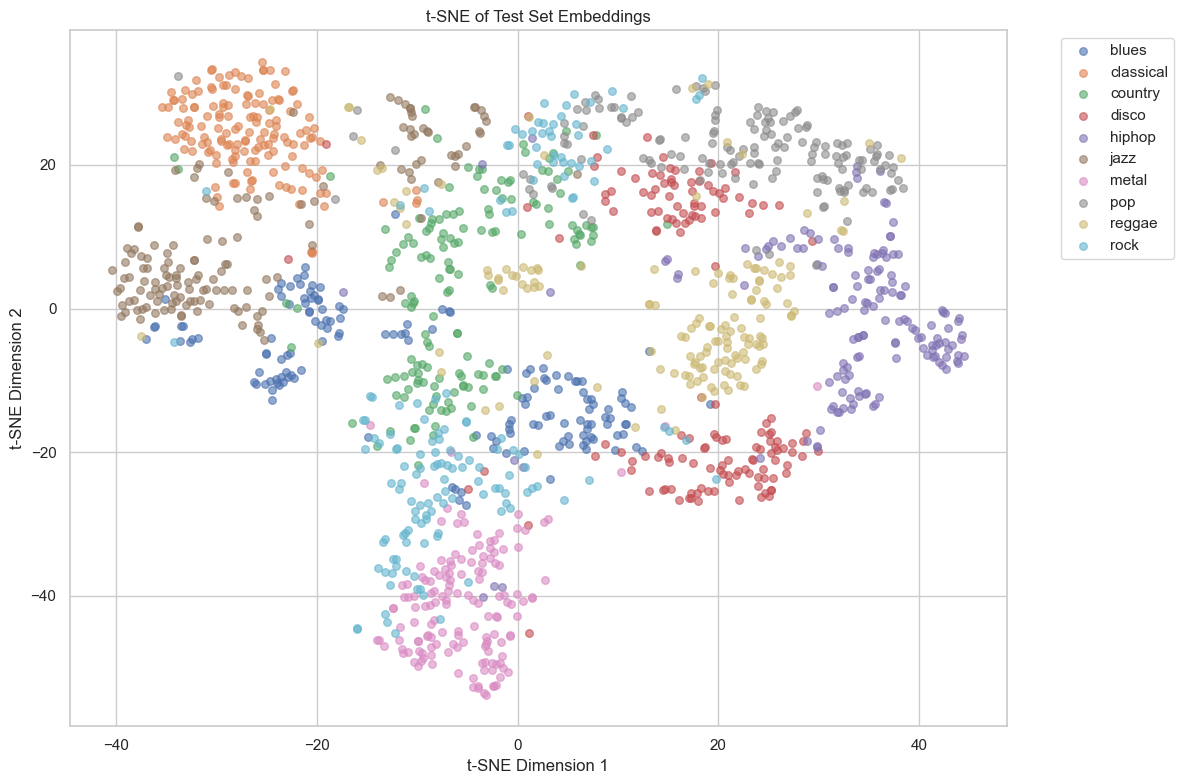

t-SNE visualization saved to report_artifacts/tsne_embeddings.png


In [ ]:
# ------------------------------
# 10. Embeddings + t-SNE (analysis) - FIXED
# ------------------------------

embedding_model = models.Sequential()

found_embedding = False
for layer in model.layers:
    embedding_model.add(layer)
    if layer.name == "embedding":
        found_embedding = True
        break

if not found_embedding:
    raise ValueError("Embedding layer not found in model")

embeddings_test = embedding_model.predict(X_test, verbose=0)
print("Embeddings shape:", embeddings_test.shape)

print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_test)

plt.figure(figsize=(12, 8))
for i, genre in enumerate(label_enc.classes_):
    mask = y_test == i
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                label=genre, alpha=0.6, s=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE of Test Set Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.savefig(pathlib.Path(REPORT_DIR) / "tsne_embeddings.png", dpi=150, bbox_inches='tight')
plt.show()
print("t-SNE visualization saved to report_artifacts/tsne_embeddings.png")


In [ ]:
# ------------------------------
# 11. Save model + label encoder
# ------------------------------
model.save(MODEL_PATH)
with open(LABEL_ENCODER_JSON, "w") as f:
    json.dump(list(label_enc.classes_), f)
print("Saved model to", MODEL_PATH)
print("Saved label encoder classes to", LABEL_ENCODER_JSON)


Saved model to report_artifacts\genre_cnn.keras
Saved label encoder classes to label_encoder.json


In [ ]:
# ------------------------------
# 12. Inference helper
# ------------------------------
def predict_genre(audio_path, model=model, label_enc=label_enc, seg_len=SEG_LEN):
    """Return predicted genre and confidence dict for a file path."""
    y, sr = load_audio(audio_path, sr=SAMPLE_RATE, duration=DURATION)
    segments = slice_into_segments(y, sr, seg_len=seg_len)
    if not segments:
        raise ValueError("Audio too short for segmentation.")
    X_inf = np.array([audio_to_mel(seg, sr) for seg in segments])[..., np.newaxis]
    probs = model.predict(X_inf, verbose=0) 
    avg = probs.mean(axis=0)
    pred_idx = int(np.argmax(avg))
    genre = label_enc.classes_[pred_idx]
    conf = {str(label_enc.classes_[i]): float(avg[i]) for i in range(len(avg))}
    return genre, conf

example_test_file = pathlib.Path(EXTRACT_DIR) / "genres_original" / "blues" / "blues.00000.wav"
if example_test_file.exists():
    print("Sanity check prediction:", predict_genre(str(example_test_file)))
else:
    print(f"Sanity check file not found: {example_test_file}")


Sanity check prediction: (np.str_('blues'), {'blues': 0.9243532419204712, 'classical': 6.802500820413115e-07, 'country': 0.0015204758383333683, 'disco': 0.0009894913528114557, 'hiphop': 0.0008403309620916843, 'jazz': 0.025136074051260948, 'metal': 0.0005908606690354645, 'pop': 3.7814274946867954e-06, 'reggae': 0.0005374487373046577, 'rock': 0.04602763056755066})


In [ ]:
# ------------------------------
# 13. Gradio interface (fixed launch)
# ------------------------------
import gradio as gr
import traceback

def gradio_fn(audio):
    try:
        genre, conf = predict_genre(audio)
        return genre, conf
    except Exception as e:
        traceback.print_exc()
        return f"ERROR: {e}", {}

iface = gr.Interface(
    fn=gradio_fn,
    inputs=gr.Audio(type="filepath", label="Upload .wav"),
    outputs=[gr.Label(num_top_classes=3, label="Predicted Genre"),
             gr.JSON(label="Confidence scores")],
    title="🎵 Deep-Learning Genre Detector (GTZAN)",
    description="Drag & drop a 30-second .wav file (any genre). The CNN was trained on GTZAN.",
    examples=[],
    cache_examples=False
)

iface.launch(share=True)  

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://80a12afcbed85231b7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\keert\AppData\Local\Programs\Python\Python313\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        self.scope, self.receive, self.send
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\keert\AppData\Local\Programs\Python\Python313\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\keert\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastapi\applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\keert\AppData\Local\Programs\Python\Python313\Lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.midd